## Comparing KGs to real-world complex networks

Using three sub-KGs from the Wikidata as target

# Environment Setup

Install & imports

In [ ]:
# Install required packages
import sys
!pip install -q rdflib networkx matplotlib
!{sys.executable} -m pip install rdflib networkx matplotlib --user

# Imports
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections

Auxiliary functions

In [ ]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def histogram(l):
    degree_sequence = sorted([d for n, d in list(l.items())], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    print(deg, cnt)

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Histogram")
    plt.ylabel("Count")
    plt.xlabel("Value")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))

    Ref.: https://stackoverflow.com/a/62662992
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

rdfs = {'oracle': 'https://www.wikidata.org/wiki/Special:EntityData/Q19900.ttl',
        'movie': 'https://www.wikidata.org/wiki/Special:EntityData/Q11424.ttl',
        'merged': 'http://www.ic.unicamp.br/~ra124136/kgs/wikidata_merged_oracle_movie.ttl'}

## Loading RDF model

Pointing to a remote Turtle (*.ttl) file.

In [ ]:
rgs = dict()
for i in rdfs.keys():
    rg = RDFGraph()
    rg.parse(rdfs[i], format='ttl') # Turtle format

    print("rdflib Graph {} loaded successfully with {} triples".format(i, len(rg)))
    rgs[i] = rg

rdflib Graph oracle loaded successfully with 7345 triples
rdflib Graph movie loaded successfully with 8747 triples
rdflib Graph merged loaded successfully with 15051 triples


## Converting rdflib.Graph to networkx.MultiDiGraph

KGs are directed graphs with the possibility of multiple paralell edges.

In [ ]:
TKG = dict()
for i in rgs:
    # Conversion of rdflib.Graph to networkx.MultiDiGraph
    KG = rdflib_to_networkx_multidigraph(rgs[i])
    print("networkx Graph loaded successfully with length {}".format(len(KG)))

    TKG[i] = KG

networkx Graph loaded successfully with length 3071
networkx Graph loaded successfully with length 4072
networkx Graph loaded successfully with length 6530


# General Network Metrics

Network size and density

In [ ]:
for i in TKG:
    # Network size
    print(f"NETWORK {i} SIZE")
    print("============")
    print("The network has {} nodes and {} edges".format(TKG[i].number_of_nodes(), TKG[i].number_of_edges()))
    print()

    # Density
    print(f"NETWORK {i} DENSITY")
    print("============")
    print("The network density is {}".format(nx.density(TKG[i])))
    print()

NETWORK oracle SIZE
The network has 3071 nodes and 7345 edges

NETWORK oracle DENSITY
The network density is 0.0007790648464091422

NETWORK movie SIZE
The network has 4072 nodes and 8747 edges

NETWORK movie DENSITY
The network density is 0.0005276552393444648

NETWORK merged SIZE
The network has 6530 nodes and 15051 edges

NETWORK merged DENSITY
The network density is 0.0003530250359041309



# Scale-free Networks

In-degree distribution -- Is it Poisson's or Power-law alike?

Text(0, 0.5, 'Frequency')

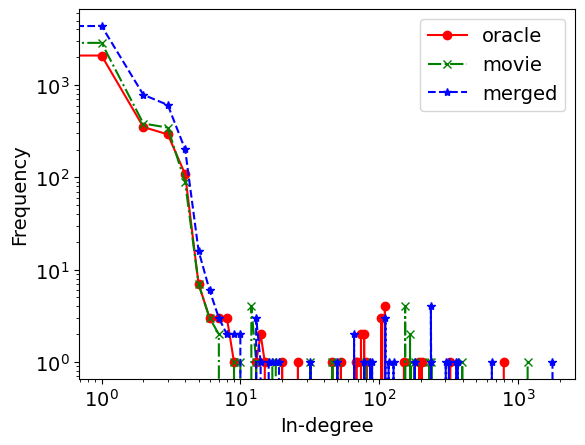

In [ ]:
styles = {'oracle': 'ro-',
          'movie': 'gx-.',
          'merged': 'b*--'}
plt.rcParams.update({'font.size': 14})
#plt.figure(figsize=(12, 8))

for i in TKG:
    degree_freq = degree_histogram_directed(TKG[i], in_degree=True)
    degrees = range(len(degree_freq))
    plt.loglog(degrees, degree_freq, styles[i], label=i)
plt.legend(loc="upper right")
plt.xlabel('In-degree')
plt.ylabel('Frequency')

Out-Degree distribution

Text(0, 0.5, 'Frequency')

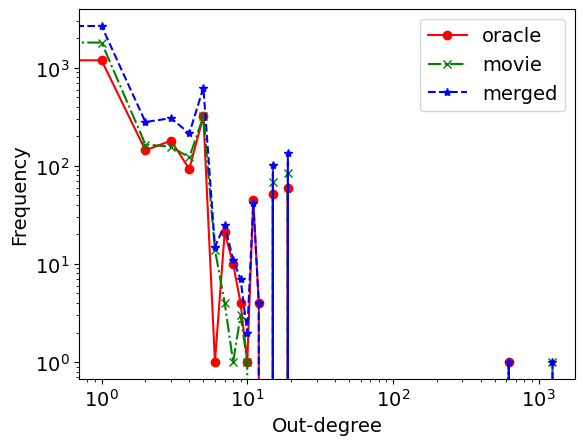

In [ ]:
plt.rcParams.update({'font.size': 14})
#plt.figure(figsize=(12, 8))

for i in TKG:
    degree_freq = degree_histogram_directed(TKG[i], out_degree=True)
    degrees = range(len(degree_freq))
    plt.loglog(degrees, degree_freq, styles[i], label=i)
plt.legend(loc="upper right")
plt.xlabel('Out-degree')
plt.ylabel('Frequency')

Are there HUBS available?

In [ ]:
for i in ['oracle']:
    h, a = nx.hits(TKG[i])

    print(f"Network {i} Hubs:")
    print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
    print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
    print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
    print("")
    print(f"Network {i} Authorities:")
    print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
    print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
    print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))
    print("")

Network oracle Hubs:
[(rdflib.term.URIRef('http://www.wikidata.org/entity/Q19900'), 0.6093205494137122), (rdflib.term.URIRef('http://www.wikidata.org/entity/Q2740714'), 0.0053925999087319565), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q19900-0EFC70C8-9754-4826-8E1D-85ADA084A04F'), 0.004317615968100703), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q19900-57d2fe1e-43b4-de55-5cf6-2ec9d000978c'), 0.004317615968100703), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q19900-4a049860-4c5d-6e51-c933-18afb621d613'), 0.004313859599869885), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q19900-57cb9715-49c9-0bc1-3ecf-2923e66a9965'), 0.004313859599869885), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q19900-314d4eb9-4bbd-ca7b-ae1f-69faeeee4523'), 0.004313859599869885), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q19900-f66fbe62-406b-75e4-8a5a-6b5710e60f12'), 0.004313859599869885), (rdflib.term.UR

In [ ]:
for i in ['movie']:
    h, a = nx.hits(TKG[i])

    print(f"Network {i} Hubs:")
    print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
    print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
    print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
    print("")
    print(f"Network {i} Authorities:")
    print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
    print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
    print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))
    print("")

Network movie Hubs:
[(rdflib.term.URIRef('http://www.wikidata.org/entity/Q11424'), 0.7787266487473935), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-BF749D0F-306B-4046-9DEC-B6382D6BBF6F'), 0.003104264806706426), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-1A686005-97D9-4122-882E-EF4F51090F93'), 0.002207097241289767), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-862C9E25-85AC-4A12-BE02-D47AED521BFE'), 0.0019079275582582595), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-2A59B558-1CF6-474C-A31E-DEF7582311D3'), 0.0019049794628282037), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-40c30787-4866-50b1-c40d-36337e677064'), 0.0016105049043691954), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-C7B20AED-324D-4046-972F-8AF3C3FC0FA2'), 0.001609829178155825), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-9F8E99AD-FCA2-4D64-A0DC-E14D5F8E

In [ ]:
for i in ['merged']:
    h, a = nx.hits(TKG[i])

    print(f"Network {i} Hubs:")
    print(sorted(h.items(), key=lambda x:x[1], reverse=True)) # Hubs - estimates the node value based on outgoing links.
    print("The mean is {}, with stdev {}".format(mean(h.values()), statistics.stdev(h.values())))
    print("The greatest hub is {}, with value {}".format(max(h, key=h.get), max(h.values())))
    print("")
    print(f"Network {i} Authorities:")
    print(sorted(a.items(), key=lambda x:x[1], reverse=True)) # Authorities - estimates the node value based on the incoming links
    print("The mean is {}, with stdev {}".format(mean(a.values()), statistics.stdev(a.values())))
    print("The greatest authority is {}, with value {}".format(max(a, key=a.get), max(a.values())))
    print("")

Network merged Hubs:
[(rdflib.term.URIRef('http://www.wikidata.org/entity/Q11424'), 0.7329396678720564), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-BF749D0F-306B-4046-9DEC-B6382D6BBF6F'), 0.0029565328548578885), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-1A686005-97D9-4122-882E-EF4F51090F93'), 0.002112051377959259), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-862C9E25-85AC-4A12-BE02-D47AED521BFE'), 0.0018304504175554765), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-2A59B558-1CF6-474C-A31E-DEF7582311D3'), 0.0018276490531677811), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-40c30787-4866-50b1-c40d-36337e677064'), 0.0015506292794394277), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-C7B20AED-324D-4046-972F-8AF3C3FC0FA2'), 0.0015498710296332372), (rdflib.term.URIRef('http://www.wikidata.org/entity/statement/Q11424-9F8E99AD-FCA2-4D64-A0DC-E14D5

# Communities

Check for communities using the Clauset-Newman-Moore Algorithm (greedy modularity - applicable to directed graphs)

In [ ]:
for k in TKG:
    comms = nx.community.greedy_modularity_communities(TKG[k])

    print(f'Network {k} -- Found {len(comms)} communities.')
    idx = 0
    for i in comms:
        print(f'Community {idx} has {len(i)} nodes.')
        #print(i)
        idx = idx + 1

Network oracle -- Found 50 communities.
Community 0 has 705 nodes.
Community 1 has 543 nodes.
Community 2 has 431 nodes.
Community 3 has 392 nodes.
Community 4 has 220 nodes.
Community 5 has 86 nodes.
Community 6 has 17 nodes.
Community 7 has 17 nodes.
Community 8 has 17 nodes.
Community 9 has 17 nodes.
Community 10 has 17 nodes.
Community 11 has 17 nodes.
Community 12 has 17 nodes.
Community 13 has 17 nodes.
Community 14 has 17 nodes.
Community 15 has 17 nodes.
Community 16 has 17 nodes.
Community 17 has 17 nodes.
Community 18 has 17 nodes.
Community 19 has 17 nodes.
Community 20 has 17 nodes.
Community 21 has 17 nodes.
Community 22 has 17 nodes.
Community 23 has 17 nodes.
Community 24 has 17 nodes.
Community 25 has 17 nodes.
Community 26 has 17 nodes.
Community 27 has 17 nodes.
Community 28 has 17 nodes.
Community 29 has 17 nodes.
Community 30 has 17 nodes.
Community 31 has 17 nodes.
Community 32 has 17 nodes.
Community 33 has 17 nodes.
Community 34 has 17 nodes.
Community 35 has 17 

# Small-world networks

Does it have a low average shortest path?

In [ ]:
for i in TKG:
    if nx.is_strongly_connected(TKG[i]):
        print(f'Network {i} -- Average shortest path length: {nx.average_shortest_path_length(TKG[i])}')
    else:
        print(f'Network {i} is NOT strongly connected!')

Network oracle is NOT strongly connected!
Network movie is NOT strongly connected!
Network merged is NOT strongly connected!


Does it have a high clustering coefficient?

In [ ]:
for i in TKG:
    # create weighted graph from M, as method is not implemented for MultiDiGraphs
    DG = nx.DiGraph()
    for u,v in TKG[i].edges():
        if DG.has_edge(u,v):
            DG[u][v]['weight'] += 1
        else:
            DG.add_edge(u, v, weight=1)

    ccs = nx.clustering(DG,weight='weight').values()

    print(f"Network {i} -- Clustering coefficient: {sum(ccs)/len(ccs)}")

Network oracle -- Clustering coefficient: 0.008063917542962576
Network movie -- Clustering coefficient: 0.007217119664123999
Network merged -- Clustering coefficient: 0.006921263657414735


# Some Centrality Measurements

NW oracle DEGREE CENTRALITY
The mean degree centrality is 0.0015581296928182623, with stdev 0.007087351443123706
The maximum node is http://www.w3.org/2002/07/owl#ObjectProperty, with value 0.25765472312703586
The minimum node is vi, with value 0.0003257328990228013
(0.25765472312703586, 0.22931596091205214, 0.10586319218241043, 0.06612377850162866, 0.06351791530944625, 0.049185667752443, 0.035830618892508145, 0.033876221498371335, 0.026384364820846908, 0.025407166123778503, 0.0241042345276873, 0.02247557003257329, 0.02214983713355049, 0.01726384364820847, 0.014983713355048861, 0.008469055374592834, 0.006514657980456026, 0.006188925081433225, 0.005211726384364821, 0.00488599348534202, 0.004560260586319219, 0.004234527687296417, 0.003908794788273616, 0.0035830618892508147, 0.003257328990228013, 0.0029315960912052116, 0.0026058631921824105, 0.0022801302931596094, 0.001954397394136808, 0.0016286644951140066, 0.0013029315960912053, 0.000977198697068404, 0.0006514657980456026, 0.00032573289

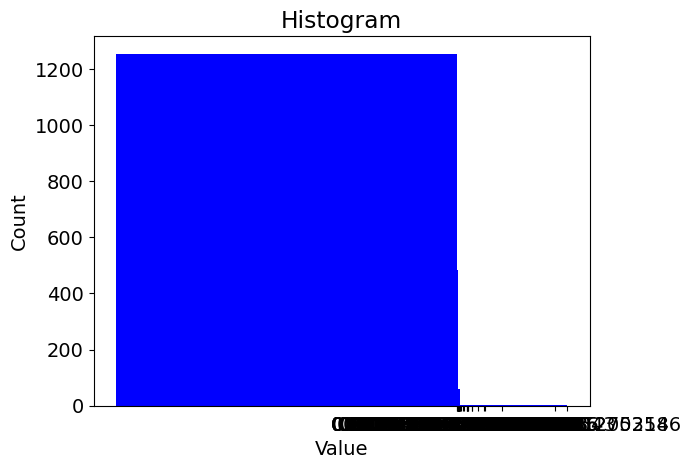


NW movie DEGREE CENTRALITY
The mean degree centrality is 0.0010553104786889327, with stdev 0.007722634920899415
The maximum node is http://www.wikidata.org/entity/Q11424, with value 0.3645295996069762
The minimum node is pellicola, with value 0.00024563989191844754
(0.3645295996069762, 0.2886268730041759, 0.09751903709162367, 0.05625153524932449, 0.04421518054532056, 0.041513141734217635, 0.04102186195038074, 0.03782854335544092, 0.019651191353475803, 0.012281994595922377, 0.011299435028248588, 0.007860476541390321, 0.005158437730287398, 0.004667157946450503, 0.004421518054532056, 0.004175878162613608, 0.003684598378776713, 0.003193318594939818, 0.0029476787030213707, 0.002702038811102923, 0.0024563989191844753, 0.002210759027266028, 0.0019651191353475803, 0.0017194792434291329, 0.0014738393515106854, 0.0012281994595922377, 0.0009825595676737902, 0.0007369196757553427, 0.0004912797838368951, 0.00024563989191844754) (1, 1, 1, 1, 1, 1, 2, 4, 1, 1, 1, 1, 10, 75, 1, 28, 42, 1, 4, 1, 3, 3,

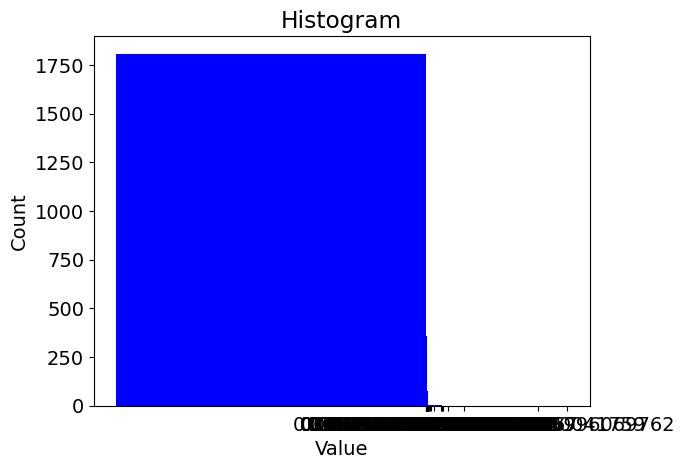


NW merged DEGREE CENTRALITY
The mean degree centrality is 0.0007060500718082003, with stdev 0.0050427012609265374
The maximum node is http://www.w3.org/2002/07/owl#ObjectProperty, with value 0.2718639914228825
The minimum node is pellicola, with value 0.00015316281206922958
(0.2718639914228825, 0.22714045029866747, 0.10736713126052994, 0.09940266503293, 0.056517077653545716, 0.05498544953285342, 0.048705774238015004, 0.04625516924490733, 0.03614642364833818, 0.027722468984530554, 0.019451677132792156, 0.01792004901209986, 0.017001072139684482, 0.013631490274161433, 0.013172001837953744, 0.010108745596569152, 0.007658140603461479, 0.0049012099862153465, 0.003216419053453821, 0.002910093429315362, 0.0027569306172461326, 0.002603767805176903, 0.0024506049931076732, 0.0022974421810384436, 0.002144279368969214, 0.0019911165568999847, 0.001837953744830755, 0.0016847909327615254, 0.0015316281206922957, 0.0013784653086230663, 0.0012253024965538366, 0.001072139684484607, 0.0009189768724153775,

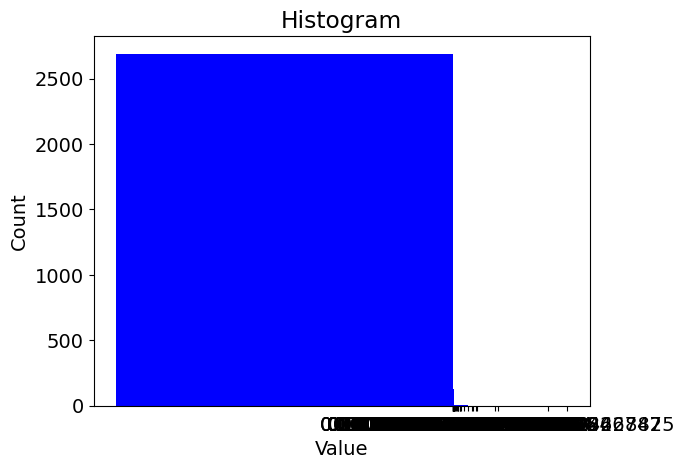


NW oracle PAGERANK
The mean network pagerank is 0.0003256268316509296, with stdev 0.0028175819235719277
The maximum node is http://www.w3.org/2002/07/owl#ObjectProperty, with value 0.14113021629469719
The minimum node is http://www.wikidata.org/entity/P4691, with value 0.00019605912863391277
(0.14113021629469719, 0.062407142340650534, 0.013677363967949625, 0.009848022507863546, 0.009045115612504165, 0.006427400018136393, 0.0062535070346938565, 0.005568030323566942, 0.005428659228624975, 0.0044168977040473624, 0.004189194553860712, 0.0037426423145660425, 0.0033863506792576213, 0.003373131579064044, 0.0031897092024218594, 0.002669720355858197, 0.001283344077726805, 0.001016275750579837, 0.000998903003237007, 0.0009775840468551136, 0.0007893138169501656, 0.0006007121032154102, 0.0005983124738594707, 0.0005080998361745355, 0.0004857672002908106, 0.0004265685926599851, 0.00041960863167130833, 0.00041342687877776924, 0.00039144035818921294, 0.00038458810252272474, 0.0003717034791624551, 0.0

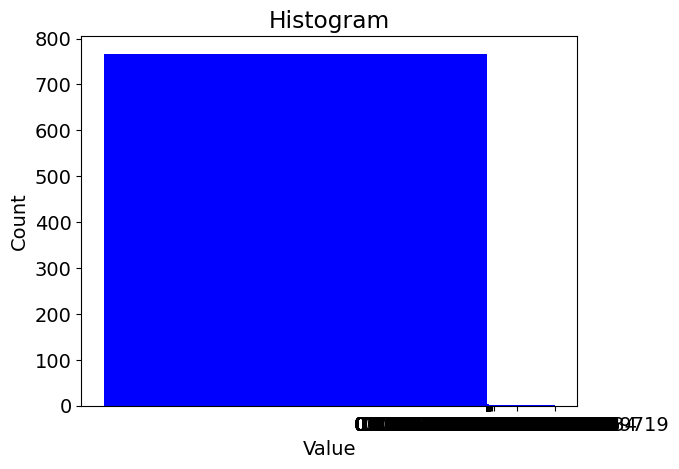


NW movie PAGERANK
The mean network pagerank is 0.0002455795677799652, with stdev 0.0027211006920101624
The maximum node is http://www.w3.org/2002/07/owl#ObjectProperty, with value 0.1602448894530242
The minimum node is http://www.wikidata.org/entity/P1256, with value 0.00014915395865805128
(0.1602448894530242, 0.05808025837864535, 0.026884940343573405, 0.010451507183080602, 0.00957873414389681, 0.006994414711292352, 0.005963884633044668, 0.005217501753335055, 0.005151937877260467, 0.005147566952188829, 0.0049028196982245816, 0.002674538882802772, 0.001968936487137583, 0.0013759583201144263, 0.0012089049051388532, 0.0006941505215993195, 0.0005917797008037755, 0.0005112783233048678, 0.00039270113768947003, 0.0003397764262925208, 0.00031458162032972864, 0.00031204716315327147, 0.0002919021302129253, 0.0002698755231718043, 0.0002682930009295947, 0.0002633524959019505, 0.0002623996719292755, 0.00026188500312927777, 0.00026171908337736474, 0.000259865499262357, 0.0002593816174325964, 0.0002

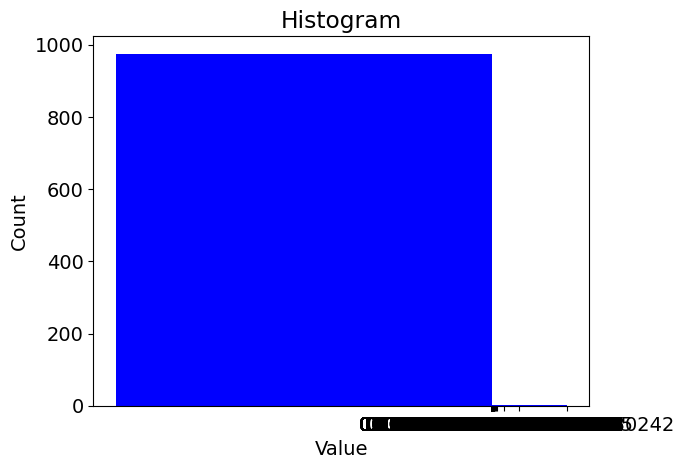


NW merged PAGERANK
The mean network pagerank is 0.00015313935681469544, with stdev 0.00201438570210903
The maximum node is http://www.w3.org/2002/07/owl#ObjectProperty, with value 0.1494874186294266
The minimum node is http://www.wikidata.org/entity/P4691, with value 9.295123105473009e-05
(0.1494874186294266, 0.05867908662928318, 0.01767225623726393, 0.009858759413975385, 0.009069811900885977, 0.0061369497954253845, 0.006014604386322802, 0.005711397798816756, 0.004839809112472162, 0.004313836639692236, 0.003139852478431117, 0.003041340571229666, 0.002819239331423799, 0.0022118203364788454, 0.0019183476437096027, 0.00179193046037746, 0.0017388469982521138, 0.0015108858444621111, 0.0015013692146447998, 0.0012285345964708617, 0.0005834545539202822, 0.0005004130303022212, 0.0004721101576691301, 0.00046056641269174924, 0.00035357532203934556, 0.00027345389837567187, 0.0002437614178528075, 0.00024001112445227364, 0.0002152966401573141, 0.00021119442170749913, 0.0002016241540050269, 0.000198

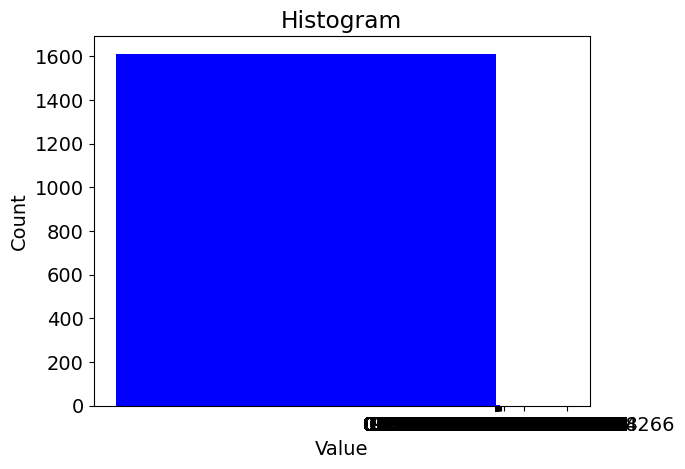


NW oracle BETWEENNESS CENTRALITY
The mean betwenness centrality is 5.645452284377304e-06, with stdev 0.0001698048918245316
The maximum node is http://www.wikidata.org/entity/Q19900, with value 0.00939881105899809
The minimum node is http://www.w3.org/2002/07/owl#Thing, with value 0.0
(0.00939881105899809, 0.00012739403913886578, 8.634753332706412e-05, 7.807985328751036e-05, 7.632011093238752e-05, 6.575653608384344e-05, 6.157900586769966e-05, 5.919795509286388e-05, 5.8904977403526194e-05, 5.198458385920809e-05, 5.165400072758829e-05, 5.101150102428355e-05, 5.0884836906186004e-05, 5.052019440489425e-05, 4.740456670518898e-05, 4.712942664534843e-05, 4.6394728526786915e-05, 4.4997264693681554e-05, 4.4875971704199566e-05, 4.374506714068442e-05, 4.3599800860576214e-05, 4.316308123530282e-05, 4.286537033407825e-05, 4.245459746142735e-05, 4.213541140626235e-05, 3.998605127164939e-05, 3.907057288004089e-05, 3.894158808355849e-05, 3.8157600283270154e-05, 3.754412425045329e-05, 3.754412425045315

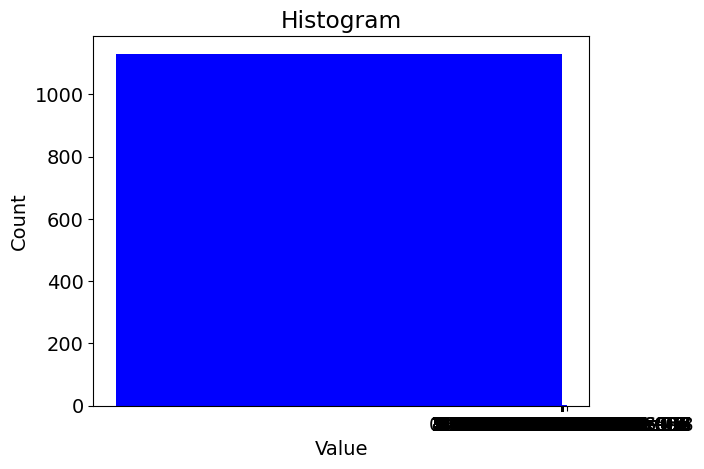


NW movie BETWEENNESS CENTRALITY
The mean betwenness centrality is 8.15059147897869e-06, with stdev 0.00033180448646821185
The maximum node is http://www.wikidata.org/entity/Q11424, with value 0.021138067121854894
The minimum node is http://wikiba.se/ontology#BestRank, with value 0.0
(0.021138067121854894, 0.00023908905937659487, 0.00023766040863867693, 0.00023766040863867688, 0.00019153807692364486, 0.00017672373311099172, 0.0001767237331109917, 0.00010198916553056461, 9.834506771588912e-05, 9.189197783573453e-05, 8.803075552484051e-05, 8.80307555248405e-05, 8.756461168080811e-05, 8.747823710685727e-05, 7.354584789328605e-05, 7.354584789328603e-05, 5.871550398129507e-05, 5.795631693657072e-05, 5.507140616661921e-05, 4.45156788483787e-05, 4.433461750298425e-05, 4.4290950131538535e-05, 4.427426372118611e-05, 4.3531763086814224e-05, 4.064685231686286e-05, 3.072960447974996e-05, 2.9866396281781964e-05, 2.984970987142943e-05, 2.9392291735696303e-05, 2.921123039030187e-05, 2.915087660850372

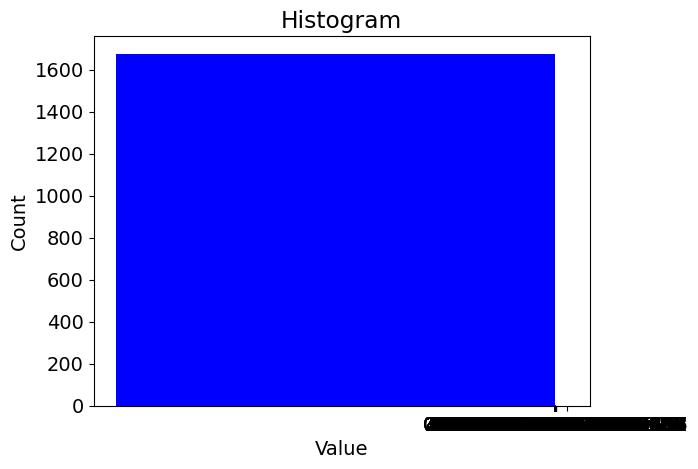


NW merged BETWEENNESS CENTRALITY
The mean betwenness centrality is 2.5421716048324046e-06, with stdev 0.00010453901848311114
The maximum node is http://www.wikidata.org/entity/Q11424, with value 0.00818285462446581
The minimum node is http://wikiba.se/ontology#BestRank, with value 0.0
(0.00818285462446581, 0.002042921625688107, 9.255887154054369e-05, 9.200580953622912e-05, 9.20058095362291e-05, 7.415045164995133e-05, 6.841539638859162e-05, 6.84153963885916e-05, 3.9482240697197314e-05, 3.8071530586033295e-05, 3.801429900247112e-05, 3.5573398097513653e-05, 3.407981236686166e-05, 3.3898179840506656e-05, 3.3864742350346755e-05, 2.847228906959674e-05, 2.8472289069596735e-05, 2.8163545097979596e-05, 2.285756239145372e-05, 2.2730058127125317e-05, 2.2436160187299365e-05, 2.1319348015961152e-05, 1.9096831083285803e-05, 1.726497231389556e-05, 1.723378003449246e-05, 1.7163392712769464e-05, 1.714599727043464e-05, 1.7139930272195132e-05, 1.6873180471178115e-05, 1.6852099330608707e-05, 1.5735287159

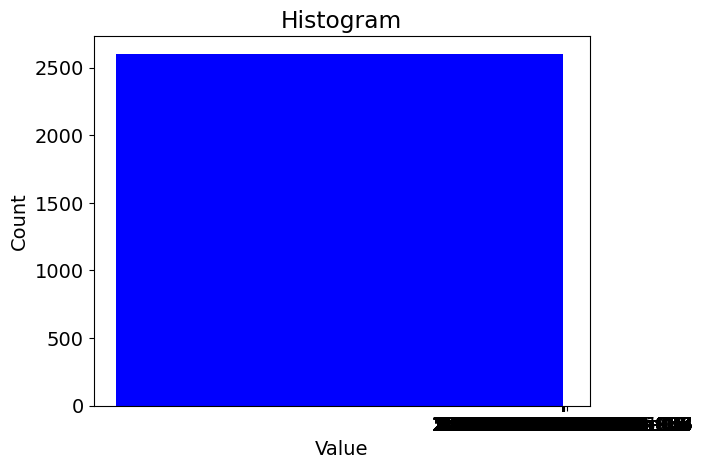

In [ ]:
for i in TKG:
    # Degree centrality -- mean and stdev
    dc = nx.degree_centrality(TKG[i])
    degrees = []
    for k,v in dc.items():
        degrees.append(v)

    print(f"NW {i} DEGREE CENTRALITY")
    print("=================")
    print("The mean degree centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(dc, key=dc.get), max(dc.values())))
    print("The minimum node is {}, with value {}".format(min(dc, key=dc.get), min(dc.values())))
    histogram(dc)
    print()

for i in TKG:
    # PageRank -- mean and stdev
    pc = nx.pagerank(TKG[i])
    degrees = []
    for k,v in pc.items():
        degrees.append(v)

    print(f"NW {i} PAGERANK")
    print("======================")
    print("The mean network pagerank is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(pc, key=pc.get), max(pc.values())))
    print("The minimum node is {}, with value {}".format(min(pc, key=pc.get), min(pc.values())))
    histogram(pc)
    print()

for i in TKG:
    # Betweenness centrality -- mean and stdev
    bc = nx.betweenness_centrality(TKG[i])
    degrees = []
    for k,v in bc.items():
        degrees.append(v)

    print(f"NW {i} BETWEENNESS CENTRALITY")
    print("======================")
    print("The mean betwenness centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(bc, key=bc.get), max(bc.values())))
    print("The minimum node is {}, with value {}".format(min(bc, key=bc.get), min(bc.values())))
    histogram(bc)
    print()